# Pole placement control

In this tutorial, I will demonstrate a pole placement technique on a rov heading control.

Assume, we can control the thrust of an ROV, so that we can make the robot rotate.

![Rov and thrusters](imgs/rov_configuration.png)

For simplification, we'll assume that the 2 thrusters are at the same distance and simplify the problem. by only considering the rotation.

$$ I \dot{\omega} = L \left( t_1 + t_2 \right) - k \omega $$

We'll assume that the input is $T=t_1+t_2$ and that the inertia is the identiy

$$ \dot{\omega} = L T - k \omega $$

Now let's re-write the system in terms of input output

$$ T = \frac {\dot{\omega} + k \omega}{L}$$

And study the Laplace transform:

$$ s W = L T - k W $$
$$ W = \frac{L T}{s + k} $$




In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import odeint

w0 = 0
w_dot0 = 0
t = np.linspace(0, 35, 1000)

L = 0.5
k = 0.01


def impulse(t):
    if 0 <= t <= 0.2:
        return 1
    return 0


def step(t):
    if 0.2 <= t:
        return 1
    return 0


def rov_update(t, x, u_fun, params={}):
    l = params.get('L', 0.5)
    k = params.get('K', 0.2)

    thrust = u_fun(t)
    h = x[0]
    w = x[1]

    wdot = L * thrust - k * w
    return [w, wdot]



Text(0.5, 1.0, '$\\omega$')

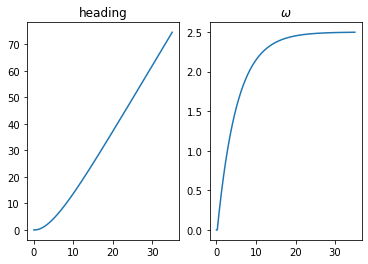

In [2]:
from scipy.integrate import solve_ivp

fig, (ax1, ax2) = plt.subplots(1, 2)
sol = solve_ivp(rov_update, [t[0], t[-1]], [w0, w_dot0], t_eval=t, args=(step,), max_step=0.01)
ax1.plot(sol.t, sol.y[0].flatten())
ax2.plot(sol.t, sol.y[1].flatten())
ax1.set_title('heading')
ax2.set_title('$\omega$')

Text(0.5, 0.98, 'Step response of the open loop system')

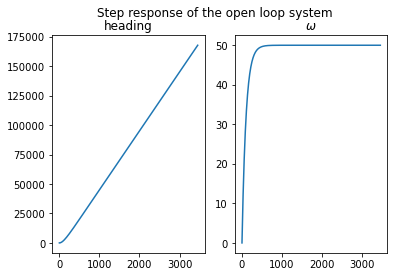

In [3]:
import control as ct

rovsys: ct.LinearIOSystem = ct.ss(np.array([[0, 1], [0, -k]]), np.array([[0], [L]]), np.eye(2),
                                  np.array([[0], [0]]), inputs=['thrust'],
                                  outputs=['heading', 'angular_rate'],
                                  states=['heading', 'angular_rate'], name='rov')
step_response = ct.step_response(rovsys)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(step_response.time, step_response.outputs[0][0])
ax2.plot(step_response.time, step_response.outputs[1][0])
ax1.set_title('heading')
ax2.set_title('$\omega$')
fig.suptitle('Step response of the open loop system')

Text(0.5, 0.98, 'response of the open loop system to a sinusoidal thrust command')

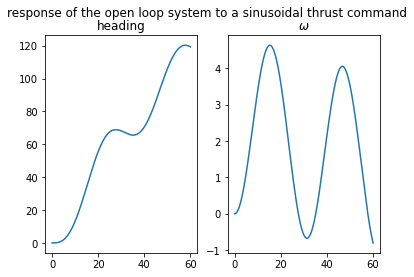

In [4]:
t_test = np.linspace(0, 60, 1000)
thrust_test = np.sin(t_test / 5)
ttt, hhh = ct.input_output_response(rovsys, t_test, thrust_test, [0, 0])
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(ttt, hhh[0])
ax2.plot(ttt, hhh[1])
ax1.set_title('heading')
ax2.set_title('$\omega$')
fig.suptitle('response of the open loop system to a sinusoidal thrust command')

In [5]:
step_response.outputs.shape

(2, 1, 251)

# Control loop

Let's write the system in classical form:

$$ \dot{X} = A X + B u \\ y = C X$$

By identification we get

$$ \dot{X} = \begin{pmatrix} 0 & 1 \\ 0 & -k \end{pmatrix} X + \begin{pmatrix}0\\L\end{pmatrix} T \\ y = I X$$

Let's design a control loop for this system in the form of
$$ T = -kX $$


In [6]:
ct.pole(rovsys)

array([ 0.  +0.j, -0.01+0.j])

In [51]:
def error(t, x, u, params={}):
    current_heading = u[0]
    desired_heading = u[1]
    z = x[0]
    return desired_heading - current_heading


def kp_ctrl(t, x, u, params={}):
    kp = params.get('kp', 0.2)
    current_heading = u[0]
    desired_heading = u[1]
    return kp * (desired_heading - current_heading)



kp_control = ct.NonlinearIOSystem(error, kp_ctrl, name='control', inputs=['h', 'href'],
                                  outputs=['thrust'], states=['error'])
kp_control = ct.linearize(kp_control, [0], [0,0], name='control', inputs=['h', 'href'],
                                  outputs=['thrust'], states=['error'])
kp_control

<LinearIOSystem:control:['h', 'href']->['thrust']>

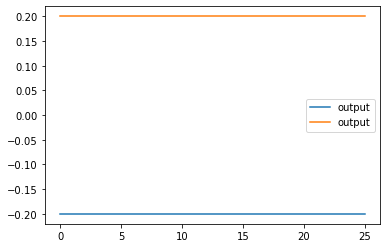

In [29]:
ttt = np.linspace(0, 600, 1000)
href_u = np.append(ttt[:50] * 0, ttt[50:] * 0 + 1)
h = np.zeros_like(ttt)
t, y = ct.step_response(kp_control)
plt.plot(t, y[0][0].flatten(), label='output')
plt.plot(t, y[0][1].flatten(), label='output')
# plt.plot(t, href_u, label='reference heading')
# plt.plot(t, x.flatten(), label='error')
plt.legend()

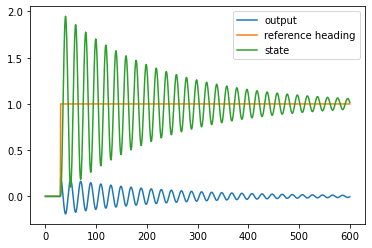

In [42]:
# ct.feedback(rovsys, kp_control)
aaa = ct.InterconnectedSystem((rovsys, kp_control), name='heading_controller', connections=(
    ('rov.thrust', 'control.thrust'),
    ('control.h', 'rov.heading'),
), inplist=('control.href'), outlist=('control.thrust'), inputs=('href'),
                              outputs=('thrust'))

t, y, x = ct.input_output_response(aaa, ttt, [href_u], [0], params={'kp': 0.2}, return_x=True)
plt.plot(t, y.flatten(), label='output')
plt.plot(t, href_u, label='reference heading')
plt.plot(t, x[0].flatten(), label='state')
plt.legend()

In [550]:
x.shape

(3, 1000)

# Propotional Control

Text(0.5, 0.98, 'Step response of the open loop system')

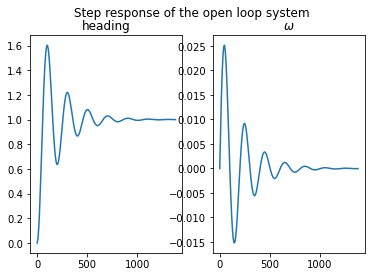

In [50]:
kp = 0.01
k = 0.01
L = 0.1
rovsys2: ct.LinearIOSystem = ct.ss(np.array([[0, 1], [-kp*L, -k]]), np.array([[0], [kp*L]]), np.eye(2),
                                  np.array([[0], [0]]), inputs=['href'],
                                  outputs=['heading', 'angular_rate'], name='rov2')
step_response = ct.step_response(rovsys2)
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(step_response.time, step_response.outputs[0][0])
ax2.plot(step_response.time, step_response.outputs[1][0])
ax1.set_title('heading')
ax2.set_title('$\omega$')
fig.suptitle('Step response of the open loop system')

ControlMIMONotImplemented: Bode is currently only implemented for SISO systems.

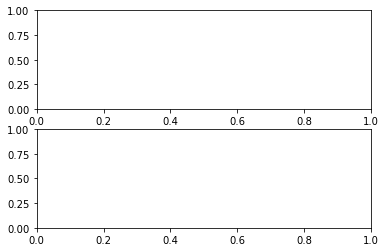

0

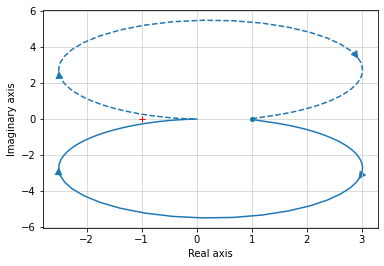

In [553]:
ct.nyquist_plot(rovsys2)


In [561]:
ct.ss2tf(rovsys2)


TransferFunction([[array([0.003])], [array([0.003, 0.   ])]], [[array([1.   , 0.01 , 0.003])], [array([1.   , 0.01 , 0.003])]])

<LinearIOSystem:rov:['thrust']->['heading', 'angular_rate']>

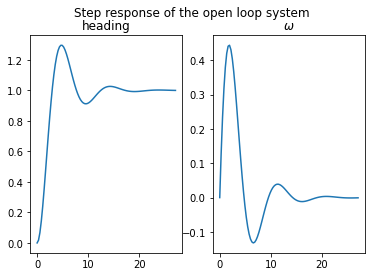

In [59]:
step_response = ct.step_response(ct.feedback(rovsys, [1,1]))
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(step_response.time, step_response.outputs[0][0])
ax2.plot(step_response.time, step_response.outputs[1][0])
ax1.set_title('heading')
ax2.set_title('$\omega$')
fig.suptitle('Step response of the open loop system')
rovsys
